In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, SimpleRNN, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Pour le prétraitement des textes
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import  stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from datasets import load_dataset

from transformers import BertTokenizer, TFBertModel, pipeline, AutoTokenizer, AutoModelForSequenceClassification
from gensim.models import KeyedVectors

# Pour la séparation des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from keras.models import load_model

from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import os
import helpers

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data collection

In [2]:
train_data = pd.read_csv('../data/train.csv',index_col='id')
print('train_data shape:', train_data.shape)
train_data.head(5)

train_data shape: (7613, 4)


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print('data keywoards:', train_data.keyword.unique()[:20])
print('\ndata location:', train_data.location.unique()[:20])

data keywoards: [nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze']

data location: [nan 'Birmingham' 'Est. September 2012 - Bristol' 'AFRICA'
 'Philadelphia, PA' 'London, UK' 'Pretoria' 'World Wide!!'
 'Paranaque City' 'Live On Webcam' 'milky way' 'GREENSBORO,NORTH CAROLINA'
 'England.' 'Sheffield Township, Ohio' 'India' 'Barbados' 'Anaheim'
 'Abuja' 'USA' 'South Africa']


In [4]:
# handle missing values
train_data['keyword'] = train_data['keyword'].fillna('')
train_data['location'] = train_data['location'].fillna('')

# concatenate keyword, location and text columns
sentences = train_data['keyword'] + ' ' + train_data['location'] + ' ' + train_data['text']

In [5]:
# preprocess sentences
sentences = sentences.apply(helpers.preprocess_text)

# train test split
X_train, X_test, y_train, y_test = train_test_split(sentences, train_data['target'], test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (6090,)
X_test shape: (1523,)


### Embeddings for sentences

In [6]:
# GloVe embeddings
dataset = load_dataset("SLU-CSCI4750/glove.6B.100d.txt")

# load the embeddings into a dictionary
embeddings_index = {}
for i in range(len(dataset['train'])):
    text = dataset['train'][i]['text'].split()
    word = text[0]
    coefs = np.asarray(text[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))
    

/Users/dabereabasse/anaconda3/envs/Py311/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Found 400000 word vectors.


In [7]:
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert the sentences to sequences
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# paddeed sequences
max_len = max([len(x) for x in sequences_train])
sequences_train = pad_sequences(sequences_train, maxlen=max_len, padding='post')
sequences_test = pad_sequences(sequences_test, maxlen=max_len, padding='post')

# Create an embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Helper function to make submission

In [8]:
def make_submission(model, tokenizer, max_len, filepath='submission.csv'):
    test_data = pd.read_csv('../data/test.csv',index_col='id')
    # handle missing values
    test_data['keyword'] = test_data['keyword'].fillna('')
    test_data['location'] = test_data['location'].fillna('')
    # concatenate keyword, location and text columns
    test_sentences = test_data['keyword'] + ' ' + test_data['location'] + ' ' + test_data['text']
    # preprocess sentences
    test_sentences = test_sentences.apply(helpers.preprocess_text)
    # Convert the sentences to sequences
    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    # paddeed sequences
    test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')
    # make predictions
    y_test_pred = model.predict(test_sequences)
    y_test_pred = (y_test_pred > 0.5).astype(int)
    # create submission dataframe
    submission = pd.DataFrame({'id': test_data.index, 'target': y_test_pred.flatten()})
    # save the submission
    submission.to_csv(filepath, index=False)
    print('Submission saved to', filepath)

### Model2_1

In [9]:
# define a random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Create a bidirectional LSTM model
model = Sequential([
    Embedding(num_words, 100, embeddings_initializer=keras.initializers.Constant(embedding_matrix), input_length=max_len, trainable=False),
    Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5)),
    Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 100)           1531700   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1620341 (6.18 MB)
Trainable params: 88641 (346.25 KB)
Non-trainable params: 1531700 (5.84 MB)
______________

In [10]:
# train the model
history = model.fit(sequences_train, y_train, epochs=10, batch_size=64, validation_data=(sequences_test, y_test))

Epoch 1/10
96/96 [==============================] - 5s 32ms/step - loss: 0.5948 - accuracy: 0.6854 - val_loss: 0.4733 - val_accuracy: 0.7925
Epoch 2/10
96/96 [==============================] - 4s 38ms/step - loss: 0.5088 - accuracy: 0.7719 - val_loss: 0.4697 - val_accuracy: 0.7951
Epoch 3/10
96/96 [==============================] - 4s 38ms/step - loss: 0.4958 - accuracy: 0.7818 - val_loss: 0.4540 - val_accuracy: 0.7951
Epoch 4/10
96/96 [==============================] - 4s 39ms/step - loss: 0.4794 - accuracy: 0.7898 - val_loss: 0.4497 - val_accuracy: 0.8004
Epoch 5/10
96/96 [==============================] - 4s 38ms/step - loss: 0.4763 - accuracy: 0.7895 - val_loss: 0.4924 - val_accuracy: 0.7840
Epoch 6/10
96/96 [==============================] - 4s 38ms/step - loss: 0.4619 - accuracy: 0.7987 - val_loss: 0.4767 - val_accuracy: 0.7938
Epoch 7/10
96/96 [==============================] - 4s 37ms/step - loss: 0.4614 - accuracy: 0.7980 - val_loss: 0.4548 - val_accuracy: 0.8142
Epoch 8/10
96

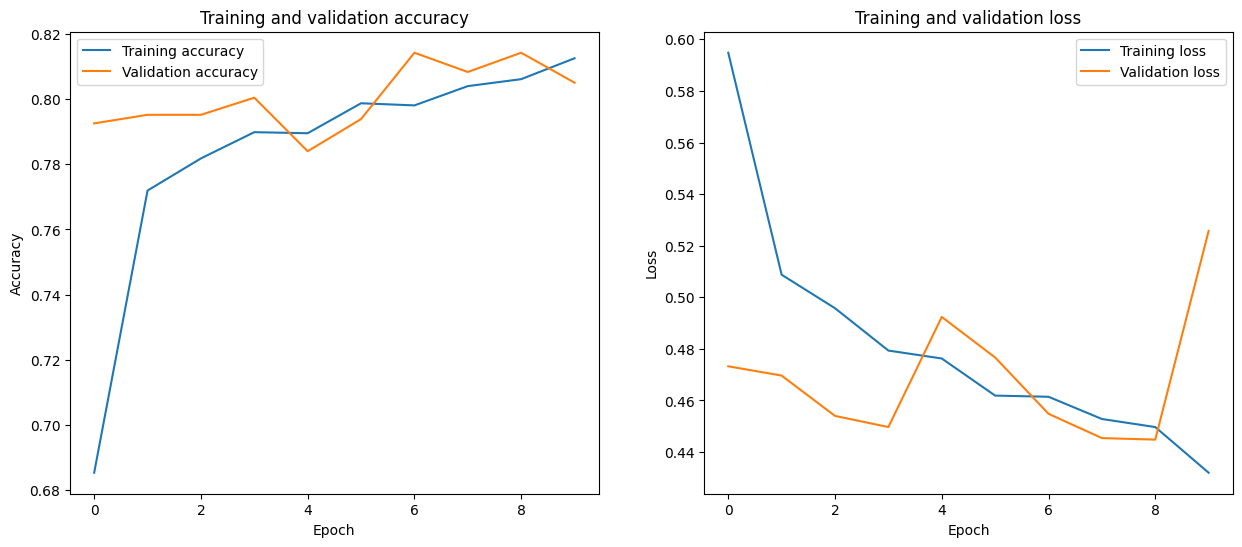

In [11]:
# plot the history
helpers.plot_history(history)

In [16]:
# save the model weights
# model.save_weights('../models/model2_1.h5')

# load the model weights
model.load_weights('../models/model2_1.h5')

In [17]:
# make predictions on train and test data
y_train_pred = model.predict(sequences_train)
y_train_pred = (y_train_pred > 0.5).astype(int)

y_test_pred = model.predict(sequences_test)
y_test_pred = (y_test_pred > 0.5).astype(int)

# print report
helpers.print_report(y_train, y_train_pred, y_test, y_test_pred)

48/48 [==============================] - 0s 4ms/step
Training set:
Accuracy: 0.8233169129720854
F1 score: 0.7933154053015751
Precision: 0.7991486068111455
Recall: 0.7875667429443173


Testing set:
Accuracy: 0.8049901510177282
F1 score: 0.7751703255109765
Precision: 0.7619047619047619
Recall: 0.7889060092449923


In [13]:
# make submission
# make_submission(model, tokenizer, max_len, filepath='../submissions/submission_1_model_2.csv')